In [1]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import transformers
from transformers import AutoTokenizer, TFAutoModel, TFElectraModel, ElectraTokenizer
import tensorflow as tf
import tensorflow.keras.layers as L
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, average_precision_score, roc_auc_score

In [2]:
# Data
train = pd.read_csv("/kaggle/input/us-patent-phrase-to-phrase-matching/train.csv")
test = pd.read_csv("/kaggle/input/us-patent-phrase-to-phrase-matching/test.csv")
train.head()


,id,anchor,target,context,score
0,37d61fd2272659b1,abatement,abatement of pollution,A47,0.50
1,7b9652b17b68b7a4,abatement,act of abating,A47,0.75
2,36d72442aefd8232,abatement,active catalyst,A47,0.25
3,5296b0c19e1ce60e,abatement,eliminating process,A47,0.50
4,54c1e3b9184cb5b6,abatement,forest region,A47,0.00


In [3]:
train.describe()

,score
count,36473.000000
mean,0.362062
std,0.258335
min,0.000000
25%,0.250000
50%,0.250000
75%,0.500000
max,1.000000


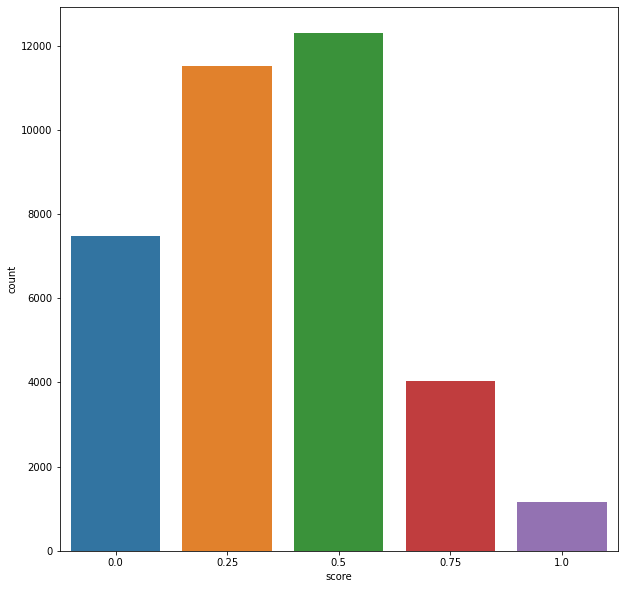

In [4]:
plt.figure(figsize=(10, 10))
sns.countplot(x='score', data=train)
plt.show()

In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36473 entries, 0 to 36472
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       36473 non-null  object 
 1   anchor   36473 non-null  object 
 2   target   36473 non-null  object 
 3   context  36473 non-null  object 
 4   score    36473 non-null  float64
dtypes: float64(1), object(4)
memory usage: 1.4+ MB


In [6]:
print(train['context'].unique())

['A47' 'A61' 'A62' 'C01' 'F16' 'F24' 'F28' 'H01' 'H04' 'B23' 'B41' 'D03'
 'E03' 'C08' 'D01' 'D21' 'C07' 'A45' 'B01' 'B08' 'G04' 'G06' 'B65' 'G16'
 'G01' 'A41' 'C23' 'F23' 'B25' 'A63' 'B28' 'B63' 'F04' 'B60' 'B32' 'C09'
 'C02' 'G03' 'C10' 'B61' 'C21' 'F42' 'A23' 'C11' 'B29' 'F02' 'B62' 'B64'
 'E21' 'B24' 'B22' 'H05' 'B27' 'E04' 'B21' 'D06' 'C04' 'B05' 'G02' 'H03'
 'C06' 'G11' 'C12' 'E02' 'F15' 'A46' 'B66' 'G07' 'G08' 'C22' 'B44' 'A01'
 'F03' 'C25' 'F22' 'G05' 'G21' 'B07' 'F41' 'E01' 'H02' 'C13' 'F01' 'F27'
 'C14' 'A44' 'B67' 'A24' 'B02' 'E05' 'D05' 'F25' 'A43' 'A22' 'A21' 'E06'
 'F21' 'G10' 'C03' 'B81' 'F17' 'B03' 'G09' 'D04' 'F26' 'B31']


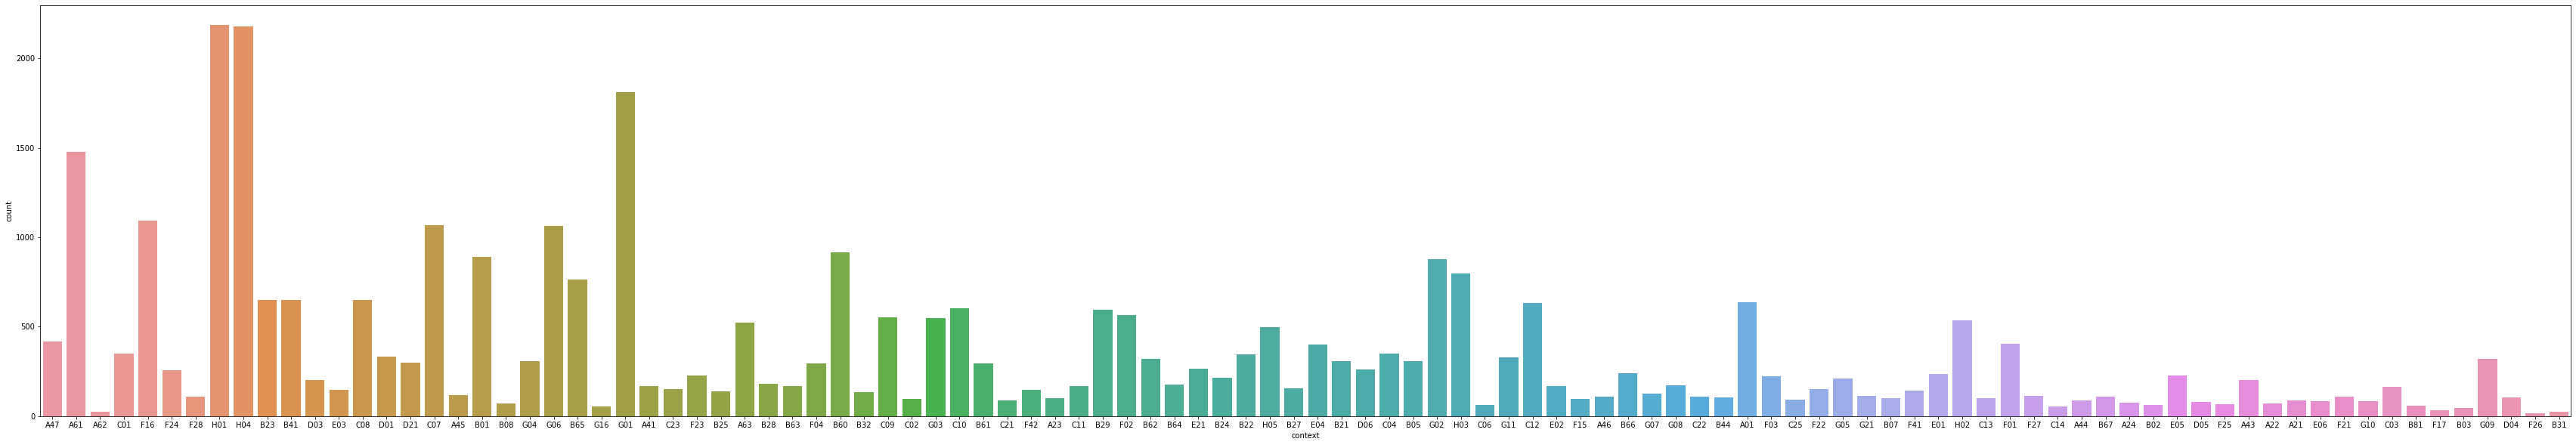

In [7]:
plt.figure(figsize=(60, 10))
sns.countplot(x='context', data=train)
plt.show()

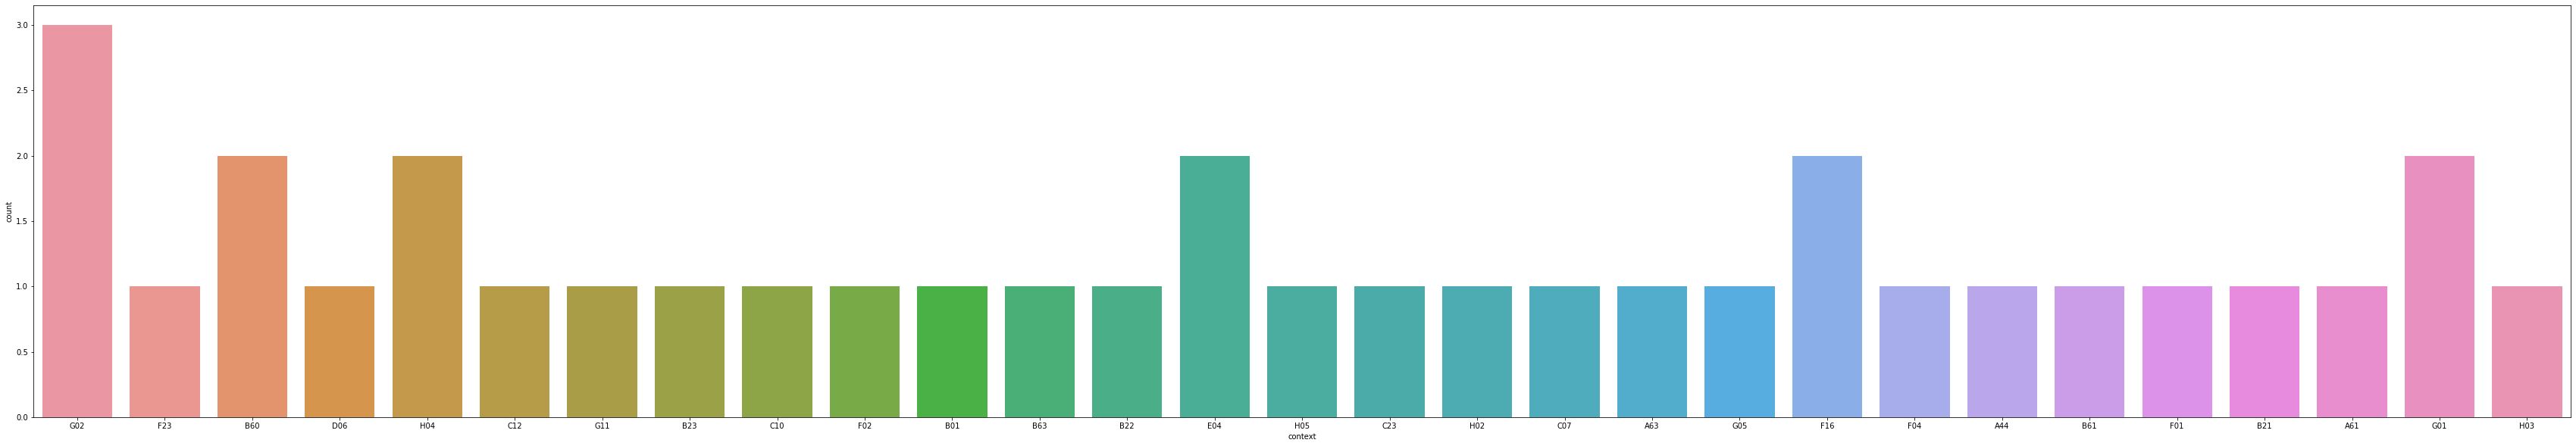

In [8]:
plt.figure(figsize=(60, 10))
sns.countplot(x='context', data=test)
plt.show()

In [9]:
coder = {
    'A': 'Human necessities',
    'B': 'Performing operations; transporting',
    'C': 'Chemistry; metallurgy',
    'D': 'Textiles; paper',
    'E': 'Fixed constructions',
    'F': 'Mechanical engineering; lighting; heating; weapons; blasting engines or pumps',
    'G': 'Physics',
    'H': 'Electricity'
}
train['context'] = train['context'].apply(lambda x: x[0])
train['context_name'] = train['context'].map(coder)
train.head()

,id,anchor,target,context,score,context_name
0,37d61fd2272659b1,abatement,abatement of pollution,A,0.50,Human necessities
1,7b9652b17b68b7a4,abatement,act of abating,A,0.75,Human necessities
2,36d72442aefd8232,abatement,active catalyst,A,0.25,Human necessities
3,5296b0c19e1ce60e,abatement,eliminating process,A,0.50,Human necessities
4,54c1e3b9184cb5b6,abatement,forest region,A,0.00,Human necessities


In [10]:
test['context'] = test['context'].apply(lambda x: x[0])
test['context_name'] = test['context'].map(coder)
test.head()

,id,anchor,target,context,context_name
0,4112d61851461f60,opc drum,inorganic photoconductor drum,G,Physics
1,09e418c93a776564,adjust gas flow,altering gas flow,F,Mechanical engineering; lighting; heating; wea...
2,36baf228038e314b,lower trunnion,lower locating,B,Performing operations; transporting
3,1f37ead645e7f0c8,cap component,upper portion,D,Textiles; paper
4,71a5b6ad068d531f,neural stimulation,artificial neural network,H,Electricity


In [11]:
import sys
sys.path.append('../input/electra')
tokenizer = ElectraTokenizer.from_pretrained('../input/electra/base-discriminator')

encoded = tokenizer.batch_encode_plus(
    [(k[2] + '[SEP]' + k[0], k[1]) for k in zip(train['anchor'].tolist(),train['target'].tolist(),train['context_name'].tolist())],
    add_special_tokens=True,
    max_length=60,
    truncation=True,
    padding='max_length',
    return_attention_mask=True,
    return_token_type_ids=True,
    return_tensors="tf",
)

# Convert batch of encoded features to numpy array.
input_ids = np.array(encoded["input_ids"], dtype="int32")
attention_masks = np.array(encoded["attention_mask"], dtype="int32")
token_type_ids = np.array(encoded["token_type_ids"], dtype="int32")

encoded_train = {
    "input_ids": input_ids,
    "attention_masks": attention_masks,
    "token_type_ids": token_type_ids
}

print(encoded_train)

train_x = [encoded_train["input_ids"], encoded_train["attention_masks"], encoded_train["token_type_ids"]]
train_y = np.array(train['score'].values.tolist())

print('#############################')

print(train_x)
print(train_y)

2022-05-24 12:04:30.270482: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-24 12:04:30.271622: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-24 12:04:30.272417: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-24 12:04:30.274877: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

{'input_ids': array([[  101,  2529, 26785, ...,     0,     0,     0],
       [  101,  2529, 26785, ...,     0,     0,     0],
       [  101,  2529, 26785, ...,     0,     0,     0],
       ...,
       [  101,  4488,  3136, ...,     0,     0,     0],
       [  101,  4488,  3136, ...,     0,     0,     0],
       [  101,  4488,  3136, ...,     0,     0,     0]], dtype=int32), 'attention_masks': array([[1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       ...,
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0]], dtype=int32), 'token_type_ids': array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32)}
#############################
[array([[  101,  2529, 26785, ...,     0,     0,     0],
       [  101,  2529, 26785, ...,     0,     0,     0],
     

ead from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-24 12:04:35.278922: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 14969 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


In [12]:
encoded = tokenizer.batch_encode_plus(
    [(k[2] + '[SEP]' + k[0], k[1]) for k in zip(test['anchor'].tolist(),test['target'].tolist(),test['context_name'].tolist())],
    add_special_tokens=True,
    max_length=60,
    padding='max_length',
    truncation=True,
    return_attention_mask=True,
    return_token_type_ids=True,
    return_tensors="tf",
)

input_ids = np.array(encoded["input_ids"], dtype="int32")
attention_masks = np.array(encoded["attention_mask"], dtype="int32")
token_type_ids = np.array(encoded["token_type_ids"], dtype="int32")

encoded_test = {
    "input_ids": input_ids,
    "attention_masks": attention_masks,
    "token_type_ids": token_type_ids
}

print(encoded_test)

test_x = [encoded_test["input_ids"], encoded_test["attention_masks"], encoded_test["token_type_ids"]]

print('#############################')

print(test_x)

{'input_ids': array([[ 101, 5584,  102, ...,    0,    0,    0],
       [ 101, 6228, 3330, ...,    0,    0,    0],
       [ 101, 4488, 3136, ...,    0,    0,    0],
       ...,
       [ 101, 5584,  102, ...,    0,    0,    0],
       [ 101, 6451,  102, ...,    0,    0,    0],
       [ 101, 6228, 3330, ...,    0,    0,    0]], dtype=int32), 'attention_masks': array([[1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       ...,
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0]], dtype=int32), 'token_type_ids': array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32)}
#############################
[array([[ 101, 5584,  102, ...,    0,    0,    0],
       [ 101, 6228, 3330, ...,    0,    0,    0],
       [ 101, 4488, 3136, ...,    0,    0,    0],
   

In [13]:
# Modeling

input_ids_layer = L.Input(shape=(60, ), dtype=tf.int32)
attention_masks_layer = L.Input(shape=(60, ), dtype=tf.int32)
token_type_ids_layer = L.Input(shape=(60, ), dtype=tf.int32)


model = TFElectraModel.from_pretrained('../input/electra/base-discriminator')

x = model(input_ids_layer, attention_mask=attention_masks_layer, token_type_ids=token_type_ids_layer)[0]
x = x[:, 0, :]
x = L.Dense(1, activation='linear', name='linear')(x)
model = Model(inputs=[input_ids_layer, attention_masks_layer, token_type_ids_layer], outputs=x)
model.compile(
    loss='mse',
    metrics=['mse'],
    optimizer=Adam(learning_rate=5e-5))

Some layers from the model checkpoint at ../input/electra/base-discriminator were not used when initializing TFElectraModel: ['discriminator_predictions']
- This IS expected if you are initializing TFElectraModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFElectraModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFElectraModel were initialized from the model checkpoint at ../input/electra/base-discriminator.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFElectraModel for predictions without further training.


In [14]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 60)]         0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 60)]         0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 60)]         0                                            
__________________________________________________________________________________________________
tf_electra_model (TFElectraMode TFBaseModelOutputWit 108891648   input_1[0][0]                    
                                                                 input_2[0][0]                

In [15]:
early_stop = EarlyStopping(monitor='val_mse', min_delta=0.001,
                           patience=3, verbose=1, mode='auto')
callbacks = [early_stop]

train_history = model.fit(train_x, train_y,
                 batch_size=32, epochs=30,
                 validation_split=0.2,
                 callbacks=callbacks)

2022-05-24 12:04:52.316457: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/30
912/912 [==============================] - 256s 264ms/step - loss: 0.0693 - mse: 0.0693 - val_loss: 0.0354 - val_mse: 0.0354
Epoch 2/30
912/912 [==============================] - 239s 262ms/step - loss: 0.0326 - mse: 0.0326 - val_loss: 0.0299 - val_mse: 0.0299
Epoch 3/30
912/912 [==============================] - 239s 262ms/step - loss: 0.0223 - mse: 0.0223 - val_loss: 0.0322 - val_mse: 0.0322
Epoch 4/30
912/912 [==============================] - 239s 262ms/step - loss: 0.0176 - mse: 0.0176 - val_loss: 0.0384 - val_mse: 0.0384
Epoch 5/30
912/912 [==============================] - 239s 262ms/step - loss: 0.0142 - mse: 0.0142 - val_loss: 0.0325 - val_mse: 0.0325
Epoch 00005: early stopping


In [16]:
pred = model.predict(test_x)

In [17]:
submission = pd.read_csv("/kaggle/input/us-patent-phrase-to-phrase-matching/sample_submission.csv")

In [18]:
submission['score'] = pred

In [19]:
submission.head()

,id,score
0,4112d61851461f60,0.416240
1,09e418c93a776564,0.721228
2,36baf228038e314b,0.519273
3,1f37ead645e7f0c8,0.351903
4,71a5b6ad068d531f,-0.054144


In [20]:
def submission_formatter(sub):
    if sub < 0.125:
        sub = 0.0
    elif sub < 0.375:
        sub = 0.25
    elif sub < 0.625:
        sub = 0.5
    elif sub < 0.875:
        sub = 0.75
    else:
        sub = 1.0
    return sub
submission['score'] = submission['score'].apply(lambda x: submission_formatter(x))

In [21]:
submission.describe()

,score
count,36.000000
mean,0.333333
std,0.286606
min,0.000000
25%,0.000000
50%,0.250000
75%,0.500000
max,1.000000


In [22]:
submission.to_csv('submission.csv',index=False)

In [23]:
model.save('electra2.h5')